In [1]:
%matplotlib inline

import sys
sys.path.append('../src/')

import warnings
warnings.filterwarnings('ignore')

import cv2
import torch
import wider_dataset
import choke_point_dataset

import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 10)

from benchmark.models import Detector
from benchmark.core import TsvHandle, run_detection, run_detection_video
from benchmark.stats import calc_precision_recall, calc_ap

# https://github.com/borhanMorphy/fastface
import fastface as ff

# FastFace Image detection

In [2]:
train, test, validation = tfds.load('wider_dataset', split=['train', 'test', 'validation'])
data = validation

In [3]:
class FastFaceDetector(Detector):
    def __init__(self):
        self.detector = ff.FaceDetector.from_pretrained("./models/fastface/lffd_original.ckpt")
        self.detector.summarize()
    
    def detect(self, image):
        try:
            predicted, = self.detector.predict(image, det_threshold=.8, iou_threshold=.4)
            return predicted['boxes'], predicted['scores']
        except Exception:
            return [], []
    
fast_face = FastFaceDetector()


  | Name | Type | Params
------------------------------
0 | arch | LFFD | 2.3 M 
------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.158     Total estimated model params size (MB)


In [4]:
with TsvHandle('fastface') as tsv:
    path, ap_path, load_path, meta_path = run_detection(
        tsv_handle = tsv, 
        samples = data, 
        detector = fast_face
    )

print("")
print(path)
print(ap_path)
print(load_path)
print(meta_path)

Running detection
[====================] 100% [3226/3226]
./results/fastface-20220619-001754.tsv
./results/fastface-20220619-001754-ap.tsv
./results/fastface-20220619-001754-load.tsv
./results/fastface-20220619-001754-metadata.tsv


In [5]:
with TsvHandle('fastface_filtered') as tsv:
    path_filtered, ap_path_filtered, load_path_filtered, meta_path_filtered = run_detection(
        tsv_handle = tsv, 
        samples = data, 
        detector = fast_face,
        filter_area = 2000)

print("")
print(path_filtered)
print(ap_path_filtered)
print(load_path_filtered)
print(meta_path_filtered)

Running detection
[====================] 100% [3226/3226]
./results/fastface_filtered-20220619-011247.tsv
./results/fastface_filtered-20220619-011247-ap.tsv
./results/fastface_filtered-20220619-011247-load.tsv
./results/fastface_filtered-20220619-011247-metadata.tsv


# Results

In [6]:
df = pd.read_csv(path, sep='\t', header=0, parse_dates=["Timestamp"])
df_filtered = pd.read_csv(path_filtered, sep='\t', header=0, parse_dates=["Timestamp"])

df_ap = pd.read_csv(ap_path, sep='\t', header=0)
df_ap = df_ap.sort_values(by=['Confidence'], ignore_index=True, ascending=False)

df_ap_filtered = pd.read_csv(ap_path_filtered, sep='\t', header=0)
df_ap_filtered = df_ap_filtered.sort_values(by=['Confidence'], ignore_index=True, ascending=False)

df_load = pd.read_csv(load_path, sep='\t', header=0, parse_dates=["Timestamp"])
df_meta = pd.read_csv(meta_path, sep='\t', header=0)

In [7]:
df_meta

,Python,CPU,GPUs
0,3.7.13.final.0 (64 bit),AMD Ryzen 7 2700X Eight-Core Processor,[]


In [8]:
df_load

,Timestamp,CPU_Load,RAM_Avail
0,2022-06-19 00:17:54.340946,2.2,6365999104
1,2022-06-19 00:18:05.914133,57.4,6355513344
2,2022-06-19 00:18:18.032135,56.6,6393982976
3,2022-06-19 00:18:29.268632,56.5,6396510208
4,2022-06-19 00:18:40.663132,45.2,6389809152
...,...,...,...
278,2022-06-19 01:11:47.262149,57.2,7319470080
279,2022-06-19 01:11:58.673649,56.8,7310499840
280,2022-06-19 01:12:09.951147,56.6,7308349440
281,2022-06-19 01:12:21.953648,55.9,7356076032


In [9]:
def plot_data_over_time(time, data, label):
    plt.plot(time, data)
    plt.xlabel('Time') 
    plt.ylabel(label)
    plt.grid(True)
    plt.show()

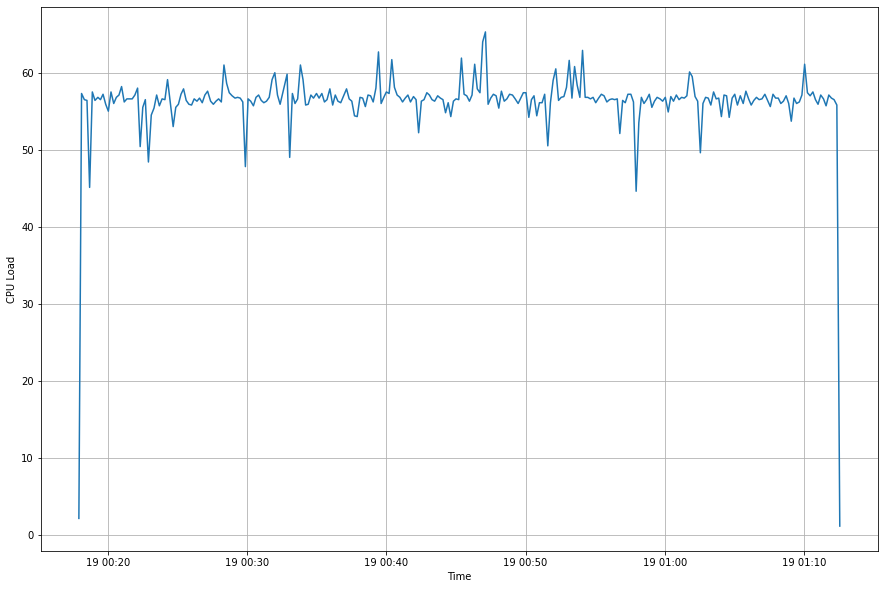

In [10]:
plot_data_over_time(df_load['Timestamp'], df_load['CPU_Load'], 'CPU Load')

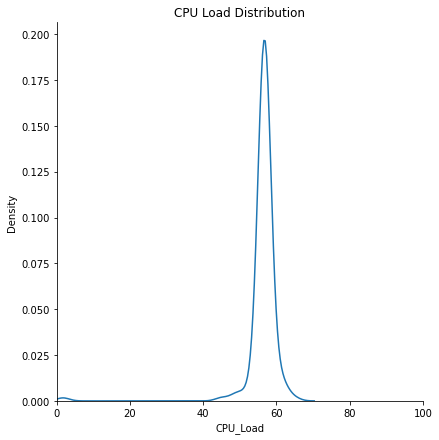

In [11]:
sns.FacetGrid(df_load, height=6).map(sns.kdeplot, 'CPU_Load').add_legend()
plt.title('CPU Load Distribution')
plt.xlim(0, 100)
plt.show()

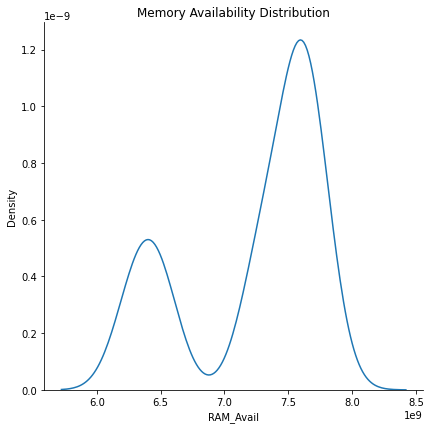

In [12]:
sns.FacetGrid(df_load, height=6).map(sns.kdeplot, 'RAM_Avail').add_legend()
plt.title('Memory Availability Distribution')
plt.show()

In [13]:
df

,Timestamp,Speed,Precision,Recall,F1_Score,Ious,Positives,False_Positives,Negatives,Num_Of_Faces,Predicted,Ground_Truth
0,2022-06-19 00:17:55.447633,921122700,1.0,1.000000,1.000000,"[0.8154292343387471, 0.7578603511637403, 0.858...",8,0,0,8,"[(778.0, 190.0, 857.0, 289.0), (603.0, 323.0, ...","[(909.0, 335.0, 974.0, 418.0), (786.0, 187.0, ..."
1,2022-06-19 00:17:57.550133,2097425100,0.0,0.000000,0.000000,[],0,0,1,1,[],"[(547.0, 1228.0, 688.0, 1333.0)]"
2,2022-06-19 00:17:58.338132,782813900,1.0,1.000000,1.000000,"[0.8438381937911571, 0.7669295621430514]",2,0,0,2,"[(460.0, 41.0, 500.0, 93.0), (555.0, 113.0, 60...","[(459.0, 45.0, 499.0, 91.0), (551.0, 107.0, 60..."
3,2022-06-19 00:17:59.243634,796303500,1.0,0.145161,0.253521,"[0.7743362831858407, 0.7935180345007841, 0.738...",9,0,53,62,"[(256.0, 496.0, 297.0, 546.0), (58.0, 494.0, 9...","[(82.0, 278.0, 90.0, 287.0), (96.0, 272.0, 106..."
4,2022-06-19 00:18:00.083133,820483800,1.0,1.000000,1.000000,"[0.9147646219686163, 0.8268525311812179, 0.902...",8,0,0,8,"[(272.0, 67.0, 317.0, 126.0), (789.0, 61.0, 83...","[(104.0, 77.0, 152.0, 135.0), (199.0, 78.0, 24..."
...,...,...,...,...,...,...,...,...,...,...,...,...
3221,2022-06-19 01:12:20.246647,1682654700,0.0,0.000000,0.000000,[],0,0,1,1,[],"[(452.0, 146.0, 587.0, 333.0)]"
3222,2022-06-19 01:12:21.953149,1700179100,0.0,0.000000,0.000000,[],0,0,2,2,[],"[(324.0, 408.0, 417.0, 524.0), (712.0, 408.0, ..."
3223,2022-06-19 01:12:22.831648,799464300,1.0,1.000000,1.000000,"[0.7758433079434167, 0.8760869565217392, 0.847...",27,0,0,27,"[(583.0, 321.0, 609.0, 353.0), (842.0, 348.0, ...","[(70.0, 307.0, 102.0, 343.0), (121.0, 301.0, 1..."
3224,2022-06-19 01:12:23.612652,766320000,1.0,1.000000,1.000000,"[0.6940459110473458, 0.8743086978381096, 0.814...",7,0,0,7,"[(113.0, 110.0, 159.0, 165.0), (577.0, 67.0, 6...","[(451.0, 94.0, 478.0, 121.0), (394.0, 99.0, 40..."


In [14]:
df.describe()

,Speed,Precision,Recall,F1_Score,Positives,False_Positives,Negatives,Num_Of_Faces
count,3.226000e+03,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000
mean,9.810402e+08,0.818234,0.687383,0.712924,5.027588,0.117793,7.281153,12.308741
std,5.782653e+08,0.361458,0.382805,0.360871,8.696191,0.379816,34.423491,39.822258
min,7.181318e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,7.836845e+08,1.000000,0.389088,0.526812,1.000000,0.000000,0.000000,1.000000
50%,8.068368e+08,1.000000,0.928571,0.888889,2.000000,0.000000,1.000000,3.000000
75%,8.435005e+08,1.000000,1.000000,1.000000,6.000000,0.000000,3.000000,9.000000
max,2.598680e+10,1.000000,1.000000,1.000000,120.000000,4.000000,649.000000,709.000000


In [15]:
speed = df['Speed'].div(1e6).round(2)
speed.describe()

count     3226.000000
mean       981.040248
std        578.265453
min        718.130000
25%        783.682500
50%        806.835000
75%        843.497500
max      25986.800000
Name: Speed, dtype: float64

### Generate Precision/Recall columns

In [16]:
all_gts = df['Positives'].sum() + df['Negatives'].sum()
df_ap = calc_precision_recall(df_ap, all_gts)

df_ap

,Confidence,TP_FP@25,TP_FP@50,TP_FP@75,Precision@25,Recall@25,Precision@50,Recall@50,Precision@75,Recall@75
0,1.000000,True,True,True,1.000000,0.000025,1.000000,0.000025,1.000000,0.000025
1,1.000000,True,True,True,1.000000,0.000050,1.000000,0.000050,1.000000,0.000050
2,1.000000,True,True,True,1.000000,0.000076,1.000000,0.000076,1.000000,0.000076
3,1.000000,True,True,True,1.000000,0.000101,1.000000,0.000101,1.000000,0.000101
4,1.000000,True,True,True,1.000000,0.000126,1.000000,0.000126,1.000000,0.000126
...,...,...,...,...,...,...,...,...,...,...
16594,0.800169,False,False,False,0.978246,0.408834,0.957698,0.400247,0.627418,0.262214
16595,0.800154,True,True,True,0.978248,0.408860,0.957701,0.400272,0.627440,0.262239
16596,0.800096,True,True,False,0.978249,0.408885,0.957703,0.400297,0.627403,0.262239
16597,0.800084,False,False,False,0.978190,0.408885,0.957645,0.400297,0.627365,0.262239


In [17]:
all_gts_filtered = df_filtered['Positives'].sum() + df_filtered['Negatives'].sum()
df_ap_filtered = calc_precision_recall(df_ap_filtered, all_gts_filtered)

df_ap_filtered

,Confidence,TP_FP@25,TP_FP@50,TP_FP@75,Precision@25,Recall@25,Precision@50,Recall@50,Precision@75,Recall@75
0,1.000000,True,True,True,1.000000,0.000140,1.000000,0.000140,1.000000,0.000140
1,1.000000,True,True,True,1.000000,0.000281,1.000000,0.000281,1.000000,0.000281
2,1.000000,True,True,True,1.000000,0.000421,1.000000,0.000421,1.000000,0.000421
3,1.000000,True,True,True,1.000000,0.000561,1.000000,0.000561,1.000000,0.000561
4,1.000000,True,True,True,1.000000,0.000702,1.000000,0.000702,1.000000,0.000702
...,...,...,...,...,...,...,...,...,...,...
5876,0.801276,False,False,False,0.956100,0.788410,0.940786,0.775782,0.703590,0.580188
5877,0.800768,True,True,False,0.956108,0.788551,0.940796,0.775923,0.703471,0.580188
5878,0.800169,False,False,False,0.955945,0.788551,0.940636,0.775923,0.703351,0.580188
5879,0.800084,False,False,False,0.955782,0.788551,0.940476,0.775923,0.703231,0.580188


In [18]:
def plot_pr(df_data, title):
    ap = calc_ap(df_data['Precision@25'], df_data['Recall@25'])
    plt.plot(df_data['Recall@25'], df_data['Precision@25'], color='darkcyan', lw=3, label="AP@0.25=%.2f" % ap)
    plt.axvline(x = df_data['Recall@25'][df_data.index[-1]], ymax=df_data['Precision@25'][df_data.index[-1]], color = 'darkcyan')
    
    ap = calc_ap(df_data['Precision@50'], df_data['Recall@50'])
    plt.plot(df_data['Recall@50'], df_data['Precision@50'], color='darkorange', lw=3, label="AP@0.5=%.2f" % ap)
    plt.axvline(x = df_data['Recall@50'][df_data.index[-1]], ymax=df_data['Precision@50'][df_data.index[-1]], color = 'darkorange')
    
    ap = calc_ap(df_data['Precision@75'], df_data['Recall@75'])
    plt.plot(df_data['Recall@75'], df_data['Precision@75'], color='mediumorchid', lw=3, label="AP@0.75=%.2f" % ap)
    plt.axvline(x = df_data['Recall@75'][df_data.index[-1]], ymax=df_data['Precision@75'][df_data.index[-1]], color = 'mediumorchid')
    
    plt.xlim(0, 1.00)
    plt.ylim(0, 1.00)

    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="lower right", prop={'size': 16})
    plt.grid(True)

    plt.show()

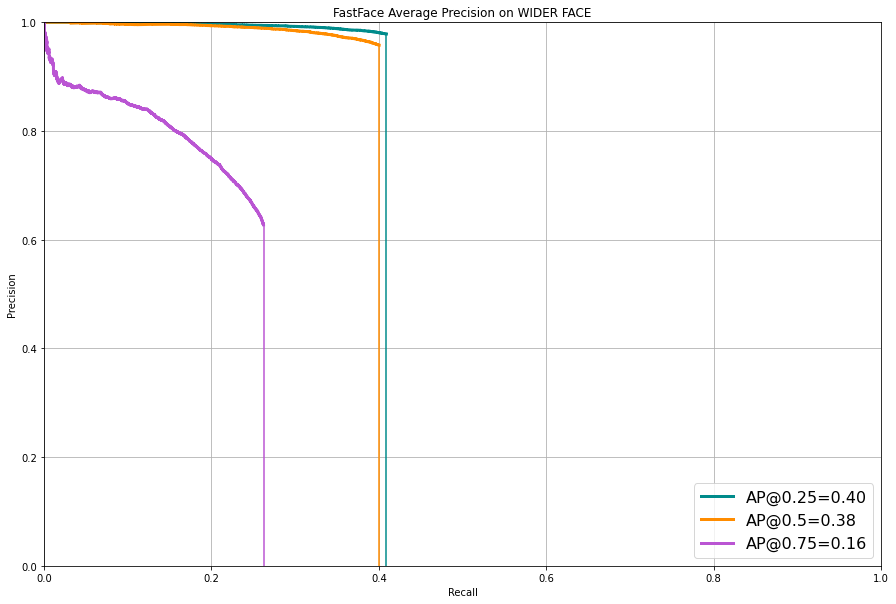

In [19]:
plot_pr(df_ap, 'FastFace Average Precision on WIDER FACE')

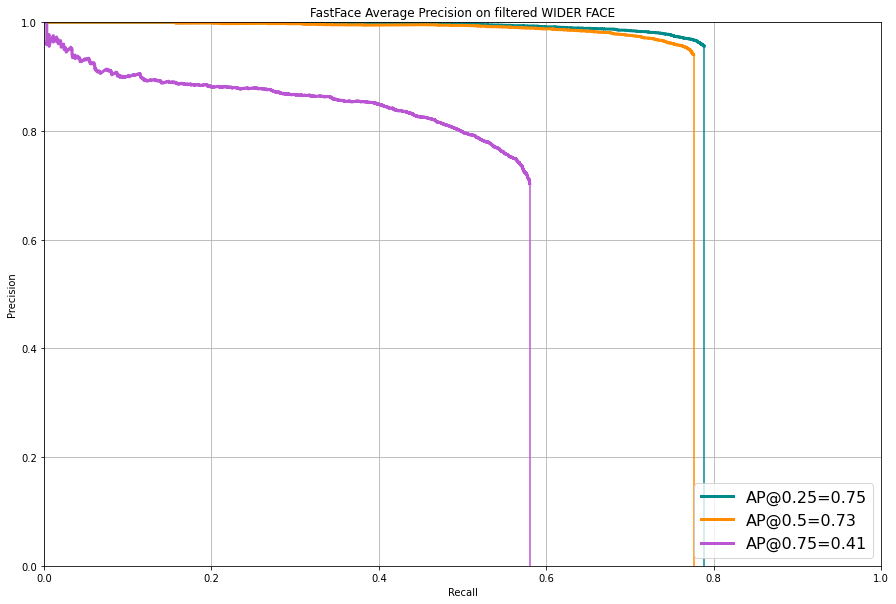

In [20]:
plot_pr(df_ap_filtered, 'FastFace Average Precision on filtered WIDER FACE')

# FastFace Video detection

In [21]:
test = tfds.load('choke_point', split=['test'])

In [22]:
data = test[0]

In [23]:
class FastFaceDetector(Detector):
    def __init__(self):
        self.detector = ff.FaceDetector.from_pretrained("./models/fastface/lffd_original.ckpt")
        self.detector.summarize()
    
    def detect(self, image):
        try:
            predicted, = self.detector.predict(image, det_threshold=.8, iou_threshold=.4)
            return predicted['boxes'], predicted['scores']
        except Exception:
            return [], []
    
fast_face = FastFaceDetector()


  | Name | Type | Params
------------------------------
0 | arch | LFFD | 2.3 M 
------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.158     Total estimated model params size (MB)


In [24]:
stt_aps, detection_percentages, mean_confidences, mean_inference_times = run_detection_video(
    samples=data, 
    detector=fast_face,
    results_folder="fastface",
    save_videos=True
)

Frames: [====================] 100% [164/164], Videos: [216/216]

In [25]:
print("Mean Video STT-AP: {0:.2f}".format(np.mean(stt_aps)))
print("Mean detection percentage of faces in all videos: {:.2f}".format(np.mean(detection_percentages)))
print("Mean confidence of boxes in all videos: {:.2f}".format(np.mean(mean_confidences)))
print("Mean inference time for all frames: {:.2f}ms".format(np.mean(mean_inference_times) / 1e+6))

Mean Video STT-AP: 0.66
Mean detection percentage of faces in all videos: 97.01
Mean confidence of boxes in all videos: 0.99
Mean inference time for all frames: 516.01ms
